In [6]:
import keras
from keras.models import Sequential, Model, load_model

from keras.layers import Dense, Dropout, Activation, Flatten, Input, Lambda
from keras.layers import Conv2D, MaxPooling2D, Conv1D, MaxPooling1D, LSTM, ConvLSTM2D, GRU, BatchNormalization, LocallyConnected2D, Permute
from keras.layers import Concatenate, Reshape, Softmax, Conv2DTranspose, Embedding, Multiply
from keras.callbacks import ModelCheckpoint, EarlyStopping, Callback
from keras import regularizers
from keras import backend as K
import keras.losses

import tensorflow as tf
from tensorflow.python.framework import ops

import isolearn.keras as iso

import numpy as np

import tensorflow as tf
import logging
logging.getLogger('tensorflow').setLevel(logging.ERROR)

import pandas as pd

import os
import pickle
import numpy as np

import scipy.sparse as sp
import scipy.io as spio

import matplotlib.pyplot as plt

import isolearn.io as isoio
import isolearn.keras as isol

import sklearn
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE

from scipy.stats import pearsonr

import seaborn as sns

from matplotlib import colors

import editdistance

def subselect_list(li, ixs) :
    return [
        li[ixs[k]] for k in range(len(ixs))
    ]

class IdentityEncoder(iso.SequenceEncoder) :
    
    def __init__(self, seq_len, channel_map) :
        super(IdentityEncoder, self).__init__('identity', (seq_len, len(channel_map)))
        
        self.seq_len = seq_len
        self.n_channels = len(channel_map)
        self.encode_map = channel_map
        self.decode_map = {
            nt: ix for ix, nt in self.encode_map.items()
        }
    
    def encode(self, seq) :
        encoding = np.zeros((self.seq_len, self.n_channels))
        
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.

        return encoding
    
    def encode_inplace(self, seq, encoding) :
        for i in range(len(seq)) :
            if seq[i] in self.encode_map :
                channel_ix = self.encode_map[seq[i]]
                encoding[i, channel_ix] = 1.
    
    def encode_inplace_sparse(self, seq, encoding_mat, row_index) :
        raise NotImplementError()
    
    def decode(self, encoding) :
        seq = ''
    
        for pos in range(0, encoding.shape[0]) :
            argmax_nt = np.argmax(encoding[pos, :])
            max_nt = np.max(encoding[pos, :])
            seq += self.decode_map[argmax_nt]

        return seq
    
    def decode_sparse(self, encoding_mat, row_index) :
        raise NotImplementError()

from keras.backend.tensorflow_backend import set_session

def contain_tf_gpu_mem_usage() :
    config = tf.ConfigProto()
    config.gpu_options.allow_growth = True
    sess = tf.Session(config=config)
    set_session(sess)

contain_tf_gpu_mem_usage()


In [7]:
#Load sequence trajectory data

def load_sequences(file_path, pick_every=1, split_on_tab=True, max_n_sequences=10) :
    seqs = []
    
    print("Processing '" + str(file_path) + "'...")
    
    try :
        with open(file_path, "rt") as f :
            i = 0
            for l in f.readlines() :
                l_strip = l.strip()
                seq = l_strip
                if split_on_tab :
                    seq = l_strip.split("\t")[0]

                if i % pick_every == 0 :
                    seqs.append(seq)
                
                i += 1
        
        if len(seqs) > max_n_sequences :
            seqs = seqs[:max_n_sequences]
        
        return seqs
    
    except FileNotFoundError :
        return []


In [8]:
#Create encoder
acgt_encoder = IdentityEncoder(145, {'A':0, 'C':1, 'G':2, 'T':3})


In [9]:
#Trajectory comparison configuration

traj_dirs = [
    "killoran",
    "fbvae/apa_fb_vae_epochs_50_kl_factor_1125_iters_150_samples_1000_q_08",
    "cbas/apa_cbas_vae_epochs_50_kl_factor_1125_iters_150_samples_1000_q_08_yt_scale_01_alpha_05_it_epochs_1",
    "cbas/apa_rwr_vae_epochs_50_kl_factor_1125_iters_150_samples_1000_q_08_yt_scale_08_alpha_05_it_epochs_10",
    "../../../../fbgan/samples/fbgan_apa_simple_sample",
    "../../../../fbgan/samples/fbgan_apa_simple_sample_median_cutoff",
    "../seqprop_samples/seqprop_apa_max_isoform_simple_20000_updates_non_normalized",
    "../seqprop_samples/seqprop_apa_max_isoform_simple_20000_updates",
    "../seqprop_samples/seqprop_apa_max_isoform_simple_20000_updates_elbo"
]

traj_file_funcs = [
    lambda i: "killoran_vae_epochs_50_kl_factor_1125_apa_seqs_iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "iter_" + str(i) + ".txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "sampled_" + str((i+1)) + "_preds.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt",
    lambda i: "intermediate_epoch_" + str(i) + "_1_steps.txt"
]

traj_scalefuncs = [
    lambda i: i * 1,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 1000,
    lambda i: i * 960,
    lambda i: i * 960,
    lambda i: i * 1,
    lambda i: i * 1,
    lambda i: i * 1
]

traj_names = [
    "AM-VAE (2000 Iters)",
    "FB-VAE (qt = .8)",
    "CBAS (qt = .8)",
    "RWR (qt = .8, alpha = 1)",
    "FBGAN (thr = .8)",
    "FBGAN (median thr)",
    "Sampled",
    "Sampled-IN",
    "Sampled-IN-VAE"
]

file_indexes = [
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000],#[0, 1, 2, 3, 4, 5, 6, 7, 8, 9],
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(15) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 1, 2, 3, 4, 5, 6, 7, 8] + ((np.arange(25) + 1) * 10 - 1).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000],#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
    [0, 5, 10, 15, 20, 25, 30, 45, 50, 55, 60, 65, 70, 75, 80, 85, 90, 95, 100, 200, 300, 400, 500, 600, 700, 800, 900, 1000, 1200, 1400, 1600, 1800, 2000, 4000, 8000, 12000, 16000, 20000]#np.arange(start=0, stop=101, step=10).tolist() + np.arange(start=100, stop=20001, step=100).tolist(),
]

traj_repeat_suffixes = [
    [""],
    ["", "_retry_1", "_retry_2"],
    ["_run_0", "_run_1", "_run_2"],
    ["_run_0", "_run_1", "_run_2"],
    [""],
    [""],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"],
    ["", "_retry_1", "_retry_2"]
]


In [ ]:
#Load sequence trajectories

model_iters = []
model_seqs = []

for model_i in range(len(traj_dirs)) :
    traj = []
    iter_scale = []
    
    for file_i in file_indexes[model_i] :
        traj_repeats = []
        
        for repeat_suffix in traj_repeat_suffixes[model_i] :
            seqs = load_sequences(traj_dirs[model_i] + repeat_suffix + "/" + traj_file_funcs[model_i](file_i), max_n_sequences=10)
            traj_repeats.append(seqs)
        
        traj.append(traj_repeats)
        iter_scale.append(traj_scalefuncs[model_i](file_i))
    
    model_seqs.append(traj)

    iter_scale = np.array(iter_scale)
    model_iters.append(iter_scale)

Design Method: am_vae_2000_iters
TCCCTACACGACGCTCTTCCGATCTCGTTATTTCCTTTTATTTACGATTTTATGCAATGTAATTAAAATCAATAAAGATAATTTTATTTTAATCGGTTTTTCGTGTTTTCGGTTGTTTTGGAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


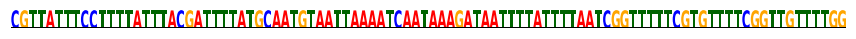

Design Method: fb_vae_qt_8
TCCCTACACGACGCTCTTCCGATCTCGCTAATTTTTTTTTTAGAGTTCCATATATCTTTTTCTTTTATTAAATAAAGTTGTTCATCAAGTCGCTCTCCATTTTTCTAAATCACGGTTTATTAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


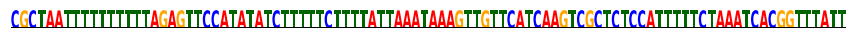

Design Method: cbas_qt_8
TCCCTACACGACGCTCTTCCGATCTTTATATTTGCGCTATGTCGTTTTTTTGGTTTTGTTGAGGGTAGTTAATAAAGGCTTTTTCCAATAAAGGCTCCCCCACTACACGTTACCTTTCTAGAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


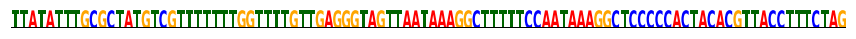

Design Method: rwr_qt_8_alpha_1
TCCCTACACGACGCTCTTCCGATCTACTGTGTTTTTGTTTTGTTCTCCCTTTGTATTCTTTTTTTTTTTAAATAAAGATCTTTTCAAACCATCTGTGTGTGTATTCTTTTCTTTTTGTTTTAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


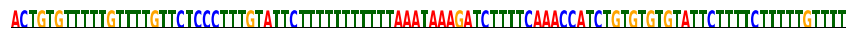

Design Method: fbgan_thr_8
TCCCTACACGACGCTCTTCCGATCTGTGTGTGTCTGTCTCGTGTGTGTGTATCTTTCAGTCGTGTGCCTAAATAAATTATTTTCGATCTCTTTTAGGCGCGTGTGTGTGTGTCTTGTCCGTAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


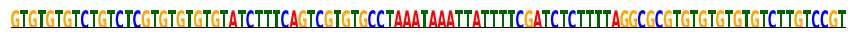

Design Method: fbgan_median_thr
TCCCTACACGACGCTCTTCCGATCTTTTGTATTTTGTAATTGTATTCTTTTGTATGTAAATTTTTTAATAAATAAAGATTTTTAAAACATGAGTGTGTGTGTGTCTCTTTATTCTGCGCCGAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


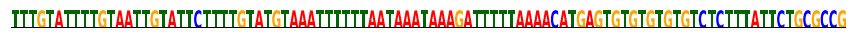

Design Method: sampled
TCCCTACACGACGCTCTTCCGATCTGTACTTTTTTTTTTTTGTAATGTAATGTAAAATTTTAATTAAATAAATAAAAAATTTTAAAAAACAATTTTTTGTGTGTGCTTTTTTTTCGCGGGGAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


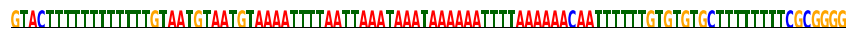

Design Method: sampled_in
TCCCTACACGACGCTCTTCCGATCTGTATGTTTTGTTTTTGTGTAACCCCCTTGTGTATTTTATTAAATAAATAAAAATTTTTTAAAACTAACCGAGTCTGAGTTGTGTGTGTTATTTCGGAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


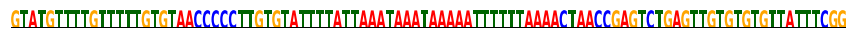

Design Method: sampled_in_vae
TCCCTACACGACGCTCTTCCGATCTGTTATTGTATTTTACTGTAACAAATGTAATGTATTTTATTAAATAAATAAAAAATTTTTGAAAACAATTTTGTTGTGGTGTATTTATTTCGCGCCGAATAAATTGTTCGTTGGTCGGCTTGAGTGCGTGTGTCTCGTTTAGATGCTGCGCCTAACCCTAAGCAGATTCTTCATGCAATTG


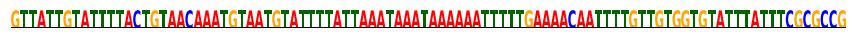

In [23]:
#Plot example sequences per method

import numpy as np

import matplotlib.pyplot as plt

import matplotlib.cm as cm
import matplotlib.colors as colors

import matplotlib as mpl
from matplotlib.text import TextPath
from matplotlib.patches import PathPatch, Rectangle
from matplotlib.font_manager import FontProperties
from matplotlib import gridspec
from matplotlib.ticker import FormatStrFormatter

def letterAt(letter, x, y, yscale=1, ax=None, color=None, alpha=1.0):

    #fp = FontProperties(family="Arial", weight="bold")
    #fp = FontProperties(family="Ubuntu", weight="bold")
    fp = FontProperties(family="DejaVu Sans", weight="bold")
    globscale = 1.35
    LETTERS = {	"T" : TextPath((-0.305, 0), "T", size=1, prop=fp),
                "G" : TextPath((-0.384, 0), "G", size=1, prop=fp),
                "A" : TextPath((-0.35, 0), "A", size=1, prop=fp),
                "C" : TextPath((-0.366, 0), "C", size=1, prop=fp),
                "UP" : TextPath((-0.488, 0), '$\\Uparrow$', size=1, prop=fp),
                "DN" : TextPath((-0.488, 0), '$\\Downarrow$', size=1, prop=fp),
                "(" : TextPath((-0.25, 0), "(", size=1, prop=fp),
                "." : TextPath((-0.125, 0), "-", size=1, prop=fp),
                ")" : TextPath((-0.1, 0), ")", size=1, prop=fp)}
    COLOR_SCHEME = {'G': 'orange', 
                    'A': 'red', 
                    'C': 'blue', 
                    'T': 'darkgreen',
                    'UP': 'green', 
                    'DN': 'red',
                    '(': 'black',
                    '.': 'black', 
                    ')': 'black'}


    text = LETTERS[letter]

    chosen_color = COLOR_SCHEME[letter]
    if color is not None :
        chosen_color = color

    t = mpl.transforms.Affine2D().scale(1*globscale, yscale*globscale) + \
        mpl.transforms.Affine2D().translate(x,y) + ax.transData
    p = PathPatch(text, lw=0, fc=chosen_color, alpha=alpha, transform=t)
    if ax != None:
        ax.add_artist(p)
    return p

def plot_simple_seqprop_logo(pwm, sequence_template=None, figsize=(12, 3), logo_height=1.0, plot_start=0, plot_end=164, save_figs=False, fig_name=None, fig_dpi=300) :

    n_samples = pwm.shape[0]

    #Slice according to seq trim index
    pwm = pwm[:, plot_start: plot_end, :]
    sequence_template = sequence_template[plot_start: plot_end]

    pwm = np.sum(pwm, axis=0)

    pwm += 0.0001
    for j in range(0, pwm.shape[0]) :
        pwm[j, :] /= np.sum(pwm[j, :])

    entropy = np.zeros(pwm.shape)
    entropy[pwm > 0] = pwm[pwm > 0] * -np.log2(pwm[pwm > 0])
    entropy = np.sum(entropy, axis=1)
    conservation = 2 - entropy

    fig = plt.figure(figsize=figsize)

    ax0 = plt.gca()
    plt.sca(ax0)

    plt.axis('off')

    height_base = (1.0 - logo_height) / 2.

    for j in range(0, pwm.shape[0]) :
        sort_index = np.argsort(pwm[j, :])

        for ii in range(0, 4) :
            i = sort_index[ii]

            nt_prob = pwm[j, i] * conservation[j]

            nt = ''
            if i == 0 :
                nt = 'A'
            elif i == 1 :
                nt = 'C'
            elif i == 2 :
                nt = 'G'
            elif i == 3 :
                nt = 'T'

            color = None
            if sequence_template[j] != 'N' :
                color = 'black'

            if ii == 0 :
                letterAt(nt, j + 0.5, height_base, nt_prob * logo_height, ax0, color=color)
            else :
                prev_prob = np.sum(pwm[j, sort_index[:ii]] * conservation[j]) * logo_height
                letterAt(nt, j + 0.5, height_base + prev_prob, nt_prob * logo_height, ax0, color=color)

    plt.xlim((0, plot_end - plot_start))
    plt.ylim((0, 2))
    plt.xticks([], [])
    plt.yticks([], [])
    plt.axis('off')
    ax0.axhline(y=0.01 + height_base, color='black', linestyle='-', linewidth=2)


    for axis in fig.axes :
        axis.get_xaxis().set_visible(False)
        axis.get_yaxis().set_visible(False)

    plt.tight_layout()

    if save_figs :
        plt.savefig(fig_name + '.png', transparent=True, dpi=fig_dpi)
        plt.savefig(fig_name + '.eps')

    plt.show()


save_figs = True

seq_len = 96
encoder = IdentityEncoder(seq_len, {'A' : 0, 'C' : 1, 'G' : 2, 'T' : 3})

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    last_ix = len(traj) - 1
    while len(traj[last_ix][0]) <= 0 :
        last_ix -= 1
    
    seq = traj[last_ix][0][0]
    
    print("Design Method: " + str(traj_name))
    print(seq)
    
    onehot = np.expand_dims(encoder.encode(seq[25:25+seq_len]), axis=0)
    
    fig_name = traj_name + "example_sequence_0"
    
    plot_simple_seqprop_logo(onehot, sequence_template="N" * seq_len, figsize=(12, 0.65), logo_height=1.0, plot_start=0, plot_end=seq_len, save_figs=save_figs, fig_name=fig_name, fig_dpi=300)


In [6]:
#Write combined fasta files

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    with open("./" + traj_name + "_combined_traj.fa", "wt") as f:
        for t in range(len(traj)) :
            for r in range(len(traj[t])) :
                for s in range(len(traj[t][r])) :
                    f.write(">t" + str(t) + "_r" + str(r) + "_s" + str(s) + "\n")
                    seq = (traj[t][r][s])
                    f.write(seq + "\n")


In [7]:
#Read DeeReCT-APA results

model_deerectapa_preds = []

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    preds = []
    
    pred_probs = np.load("./" + traj_name + "_combined_traj_DeeReCT-APA.npy")
    
    line_i = 0
    for t in range(len(traj)) :
        detect_repeats = []
        pred_repeats = []
        for r in range(len(traj[t])) :
            pred_repeat = []
            for s in range(len(traj[t][r])) :
                pred = pred_probs[line_i]
                
                pred_repeat.append(pred)
                
                line_i += 1

            #pred_repeats.append(np.array(pred_repeat))
            pred_repeats.append(np.mean(pred_repeat))

        #preds.append(np.mean(np.concatenate(pred_repeats, axis=0)))
        preds.append(np.median(pred_repeats))

    model_deerectapa_preds.append(preds)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [12]:
#Read DeepPASTA results

model_deeppasta_preds = []

for model_i in range(len(traj_dirs)) :
    traj = model_seqs[model_i]
    traj_name = traj_names[model_i]
    
    traj_name = traj_name.lower().replace(" =", "").replace("-", "_").replace("(", "").replace(")", "").replace(".", "").replace(",", "").replace(" ", "_")
    
    preds = []
    
    pred_probs = np.load("./" + traj_name + "_combined_traj_DeepPASTA.npy")
    
    line_i = 0
    for t in range(len(traj)) :
        detect_repeats = []
        pred_repeats = []
        for r in range(len(traj[t])) :
            pred_repeat = []
            for s in range(len(traj[t][r])) :
                pred = pred_probs[line_i]
                
                pred_repeat.append(pred)
                
                line_i += 1

            #pred_repeats.append(np.array(pred_repeat))
            pred_repeats.append(np.mean(pred_repeat))

        #preds.append(np.mean(np.concatenate(pred_repeats, axis=0)))
        preds.append(np.median(pred_repeats))

    model_deeppasta_preds.append(preds)


/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/fromnumeric.py:2920: RuntimeWarning: Mean of empty slice.
  out=out, **kwargs)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/core/_methods.py:85: RuntimeWarning: invalid value encountered in double_scalars
  ret = ret.dtype.type(ret / rcount)
/home/ubuntu/anaconda3/envs/tensorflow_p36/lib/python3.6/site-packages/numpy/lib/function_base.py:3250: RuntimeWarning: Invalid value encountered in median
  r = func(a, **kwargs)


In [13]:
#Join all external results

model_trajs = []

for model_i in range(len(traj_dirs)) :
    
    model_trajs.append(np.concatenate([
        np.array(model_deerectapa_preds[model_i]).reshape(-1, 1),
        np.array(model_deeppasta_preds[model_i]).reshape(-1, 1)
    ], axis=1))
    

In [14]:

def _rolling_average(x, window=1) :
    x_avg = []
    
    for j in range(x.shape[0]) :
        j_min = max(j - window + 1, 0)
        x_avg.append(np.mean(x[j_min:j+1]))
    
    return np.array(x_avg)

def plot_trajectories(iterations, measures, model_names, add_zeros, measure_ix, x_label, y_label, rolling_window=1, colors=None, figsize=(6, 4), legend_outside=False, save_fig=False, fig_name="default_1", fig_dpi=300, min_x_val=0, max_x_val=None, min_y_val=None, max_y_val=None, log10_scale=False) :
    
    f = plt.figure(figsize=figsize)
    
    max_iter_val = 0
    
    ls = []
    for model_ix, [iters, all_meas] in enumerate(zip(iterations, measures)) :
        all_meas = all_meas.T
        
        meas = np.zeros(all_meas[measure_ix, :].shape)
        meas[:] = all_meas[measure_ix, :]
        
        iters_copy = np.zeros(iters.shape)
        iters_copy[:] = iters[:]
        
        if add_zeros[model_ix] is not None :
            iters_copy = np.concatenate([np.array([0]), iters_copy], axis=0)
            meas = np.concatenate([np.array([add_zeros[model_ix]]), meas], axis=0)
        
        if log10_scale :
            iters_copy[1:] = np.log10(iters_copy[1:])
        
        max_iter_val = max(max_iter_val, np.max(iters_copy))
        
        meas = _rolling_average(meas, window=rolling_window)
        
        l1 = None
        if colors is not None :
            l1 = plt.plot(iters_copy, meas, color=colors[model_ix], linewidth=2, label=model_names[model_ix])
        else :
            l1 = plt.plot(iters_copy, meas, linewidth=2, label=model_names[model_ix])
        
        ls.append(l1[0])

    if log10_scale :
        plt.xticks(np.arange(int(max_iter_val) + 1), 10**np.arange(int(max_iter_val) + 1), fontsize=14)
    else :
        plt.xticks(fontsize=14)
    plt.yticks(fontsize=14)
    
    if max_x_val is not None :
        plt.xlim(min_x_val, max_x_val)
    else :
        plt.xlim(min_x_val, max_iter_val)
    
    if min_y_val is not None and max_y_val is not None :
        plt.ylim(min_y_val, max_y_val)

    plt.xlabel(x_label, fontsize=14)
    plt.ylabel(y_label, fontsize=14)
    
    if not legend_outside :
        plt.legend(handles=ls, fontsize=14, loc='upper left')
    else :
        plt.legend(handles=ls, fontsize=14, bbox_to_anchor=(1.04,1), loc="upper left")
    
    plt.tight_layout()
    
    if save_fig :
        plt.savefig(fig_name + ".eps")
        plt.savefig(fig_name + ".png", dpi=fig_dpi, transparent=True)
    
    plt.show()


traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .8)', 'CBAS (qt = .8)', 'RWR (qt = .8, alpha = 1)', 'FBGAN (thr = .8)', 'FBGAN (median thr)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.4458, 0.3346, 0.2563, 0.7296, 0.4395, 0.795, 0.7808, 0.7647, 0.7677]
rolling_final_scores = [0.4289, 0.3406, 0.2809, 0.7267, 0.4471, 0.7879, 0.6839, 0.7648, 0.7672]


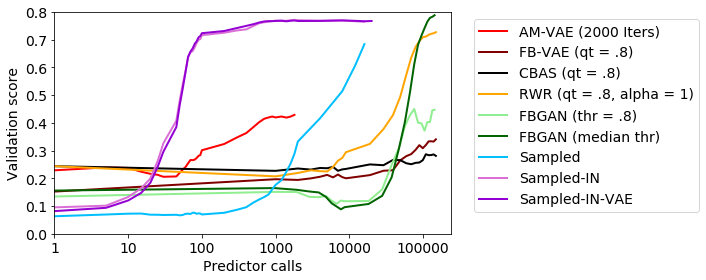

traj_names = ['AM-VAE (2000 Iters)', 'FB-VAE (qt = .8)', 'CBAS (qt = .8)', 'RWR (qt = .8, alpha = 1)', 'FBGAN (thr = .8)', 'FBGAN (median thr)', 'Sampled', 'Sampled-IN', 'Sampled-IN-VAE']
final_scores = [0.6205, 0.5173, 0.5029, 0.8269, 0.6522, 0.8838, 0.86, 0.8424, 0.819]
rolling_final_scores = [0.6036, 0.5226, 0.4874, 0.7834, 0.6689, 0.8515, 0.7267, 0.8455, 0.8305]


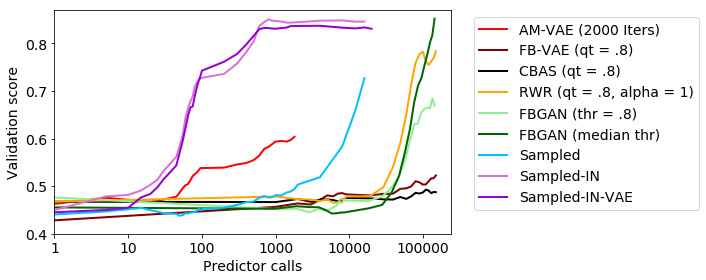

In [17]:
#Plot trajectory data

problem_prefix = "benchmark_apa_external_median_repeat"

experiment_suffix = "_traj_comparisons_log"

model_colors = ['red', 'maroon', 'black', 'orange', 'lightgreen', 'darkgreen', 'deepskyblue', 'orchid', 'darkviolet', 'indigo']

figsize = (10, 4)

save_figs = True

n_gt_predictors = 2

gt_predictor_min_y_vals = [
    [0.0, 0.4]
]

gt_predictor_max_y_vals = [
    [0.8, 0.87]
]

rolling_window = 5

for gt_predictor_ix in range(n_gt_predictors) :
    
    final_scores = [
        round([
            model_trajs[model_i][i, gt_predictor_ix]
            for i in range(model_iters[model_i].shape[0])
                if not np.isnan(model_trajs[model_i][i, gt_predictor_ix])
        ][-1], 4)
        for model_i in range(len(model_trajs))
    ]
    rolling_final_scores = [
        round([
            _rolling_average(model_trajs[model_i][:, gt_predictor_ix], window=rolling_window)[i]
            for i in range(model_iters[model_i].shape[0])
                if not np.isnan(model_trajs[model_i][i, gt_predictor_ix])
        ][-1], 4)
        for model_i in range(len(model_trajs))
    ]
    print("traj_names = " + str(traj_names))
    print("final_scores = " + str(final_scores))
    print("rolling_final_scores = " + str(rolling_final_scores))
    
    plot_trajectories(
        model_iters,
        model_trajs,
        traj_names,
        [None, None, None, None, None, None, None, None, None, None],
        gt_predictor_ix,
        'Predictor calls',
        'Validation score',
        rolling_window=rolling_window,
        colors=model_colors,
        min_x_val=0,
        max_x_val=None,
        min_y_val=gt_predictor_min_y_vals[0][gt_predictor_ix],
        max_y_val=gt_predictor_max_y_vals[0][gt_predictor_ix],
        figsize=figsize,
        save_fig=save_figs,
        fig_name=problem_prefix + experiment_suffix + "_validation_" + str(gt_predictor_ix) + "_log",
        legend_outside=True,
        log10_scale=True
    )
